In [1]:
import Feature_engineering
import matplotlib.pyplot as plt

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
import Feature_engineering

problem_title = "Bike count prediction"
_target_column_name = "log_bike_count"

X, y = Feature_engineering.get_train_data(path="data/train.parquet")

X_train, y_train, X_test, y_test = Feature_engineering.train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

print(
    f"The training dataset contains {X_train.shape[0]} samples and "
    f"{X_train.shape[1]} features"
)
print(
    f"The testing dataset contains {X_test.shape[0]} samples and "
    f"{X_test.shape[1]} features"
)

columns_encoder = FunctionTransformer(Feature_engineering._encode_columns)

date_encoder = FunctionTransformer(Feature_engineering._encode_dates)

time_encoder = FunctionTransformer(Feature_engineering.get_time_of_day)

season_encoder = FunctionTransformer(Feature_engineering.get_season)

covid_encoder = FunctionTransformer(Feature_engineering._add_covid)

meteo_encoder = FunctionTransformer(Feature_engineering._merge_external_data)

holidays_encoder = FunctionTransformer(Feature_engineering._add_holiday)

district_encoder = FunctionTransformer(
    Feature_engineering._add_arrondissement_with_geopandas
)

erase_date = FunctionTransformer(Feature_engineering.erase_date)

ordinal_cols = ["counter_installation_date"]
onehot_cols = ["counter_name"]
scale_cols = [
    "latitude",
    "longitude",
    "year",
    "month",
    "week_number",
    "day",
    "weekday",
    "hour",
    "dayofyear",
    "time_of_day",
    "season",
    "pres",
    "u",
    "tend",
    "ww",
    "rr6",
    "rr12",
    "rr24",
    "etat_sol",
    "ht_neige",
    "n",
    "t",
    "td",
    "tend24",
    "district",
]

scaler = StandardScaler()
onehot = OneHotEncoder(sparse_output=False)
ordinal = OrdinalEncoder()

preprocessor = ColumnTransformer(
    [
        ("num", scaler, scale_cols),
        ("onehot", onehot, onehot_cols),
        ("ordinal", ordinal, ordinal_cols),
    ]
)

regressor = XGBRegressor(
    max_depth=9,
    learning_rate=0.08982350073781493,
    n_estimators=394,
    subsample=0.6091504269638729,
    colsample_bytree=0.7564351155303641,
    min_child_weigh=6,
    gamma=8.981351819175658e-05,
    reg_alpha=9.853267873712797e-05,
    reg_lambda=5.602142068055845e-05,
)

pipe = make_pipeline(
    columns_encoder,
    date_encoder,
    time_encoder,
    season_encoder,
    meteo_encoder,
    covid_encoder,
    holidays_encoder,
    district_encoder,
    erase_date,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

print(f"Train set, RMSE={root_mean_squared_error(y_train, pipe.predict(X_train)):.5f}")
print(f"Valid set, RMSE={root_mean_squared_error(y_test, pipe.predict(X_test)):.5f}")

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00
The training dataset contains 456507 samples and 10 features
The testing dataset contains 40320 samples and 10 features


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:22:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_child_weigh" } are not used.

  warnings.warn(smsg, UserWarning)


Train set, RMSE=0.30141
Valid set, RMSE=0.42718


In [5]:
mask = (
    (X_test["counter_id"] == "100007049-102007049")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz = df_viz.sort_values(by="date")
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

/Users/paullacombe/Documents/Polytechnique/Python/bike_counters/Submission/Feature_engineering.py:252: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X["district"] = merged["c_ar"].fillna(21).astype(int)


Text(0, 0.5, 'bike_count')

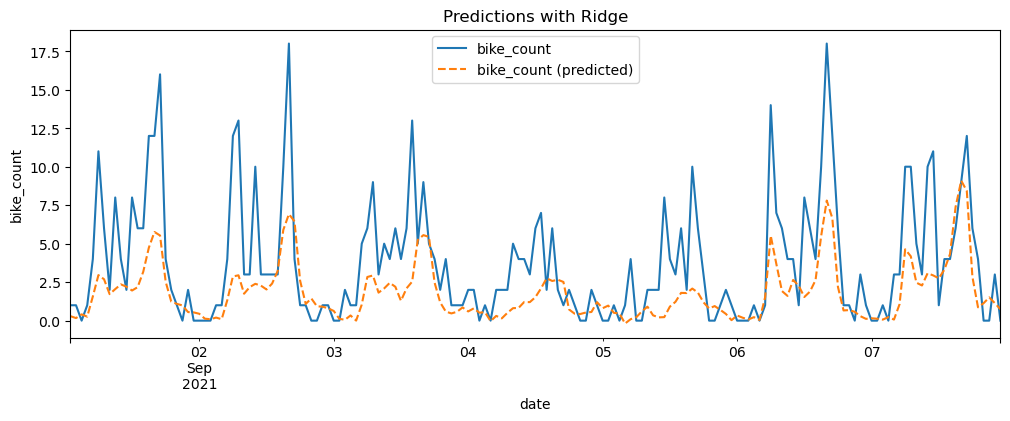

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

<Axes: xlabel='y_true', ylabel='y_pred'>

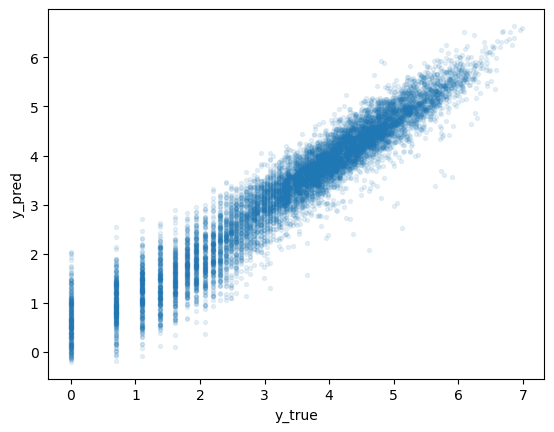

In [7]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_test, "y_pred": pipe.predict(X_test)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)